# Model coice

With my image classification task I could not simply use a regression as a baseline model as I have done previously. Also my dataset is not super simple with 100 diatom species each being representes by at least 100 samples and some with much more. Also the image qulity is in some cases questionable and the images are all off different size.

- pretrained CNN




In [3]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd

In [3]:
#get my data from kaggle
#!pip install kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

!kaggle datasets download -d michaelkloster/ude-diatoms-in-the-wild-2024

Dataset URL: https://www.kaggle.com/datasets/michaelkloster/ude-diatoms-in-the-wild-2024
License(s): CC0-1.0
100% 4.63G/4.63G [00:48<00:00, 276MB/s]
100% 4.63G/4.63G [00:48<00:00, 103MB/s]


In [4]:
#unzip the dataset
!unzip /content/ude-diatoms-in-the-wild-2024.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: UDE Diatoms in the Wild 2024-Subset_n50/UDE Diatoms in the Wild 2024-Subset_n50/val/Navicula cryptocephala/Tunesien_TWH_S02_2022.x_6355.y_41908.png  
  inflating: UDE Diatoms in the Wild 2024-Subset_n50/UDE Diatoms in the Wild 2024-Subset_n50/val/Navicula cryptotenella/Frankreich_FLB_S1_UP_20220510.x_34037.y_42040.png  
  inflating: UDE Diatoms in the Wild 2024-Subset_n50/UDE Diatoms in the Wild 2024-Subset_n50/val/Navicula cryptotenella/Frankreich_FLM_S6_20220511.x_15689.y_43936.png  
  inflating: UDE Diatoms in the Wild 2024-Subset_n50/UDE Diatoms in the Wild 2024-Subset_n50/val/Navicula cryptotenella/Frankreich_FLM_S6_20220511.x_22586.y_44152.png  
  inflating: UDE Diatoms in the Wild 2024-Subset_n50/UDE Diatoms in the Wild 2024-Subset_n50/val/Navicula cryptotenella/Frankreich_FLM_S6_20220511.x_26439.y_43667.png  
  inflating: UDE Diatoms in the Wild 2024-Subset_n50/UDE Diatoms in the Wild 2024-Subset_n5

As training really did not work I had to create a subset of my data. Only using 10 classes instead of the 101 I was starting out with.


**Ask in feedback session how to work with my full dataset**

In [21]:
#create subset of data as trainig with all 101 classes absolutely did not work

# Zielordner für die reduzierte Teilmenge erstellen
!mkdir /content/diatoms_subset
!mkdir /content/diatoms_subset_val

# Nur die ersten 10 Klassenordner aus deinem Trainingspfad auswählen und kopieren
!find "/content/UDE Diatoms in the Wild 2024-Subset_n100/UDE Diatoms in the Wild 2024-Subset_n100/train" -mindepth 1 -maxdepth 1 -type d | head -n 10 | xargs -I{} cp -r {} /content/diatoms_subset/

!find "/content/UDE Diatoms in the Wild 2024-Subset_n100/UDE Diatoms in the Wild 2024-Subset_n100/val" -mindepth 1 -maxdepth 1 -type d | head -n 10 | xargs -I{} cp -r {} /content/diatoms_subset_val/



mkdir: cannot create directory ‘/content/diatoms_subset_val’: File exists


In [22]:
# Image size for EfficientNet
img_size = 160 #choose small size as model tock forever with 240
batch_size = 16 #also reduced it down from 32
subset_path = "/content/diatoms_subset"
subset_path_val = "/content/diatoms_subset_val"


train_dataset = image_dataset_from_directory(
    subset_path,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    #validation_split=0.2,
    #subset='training',
    seed=123,
    label_mode='int'
)



val_dataset = image_dataset_from_directory(
    subset_path_val,
    image_size=(img_size,img_size),
    batch_size=batch_size,
    #validation_split=0.2,
    #subset='validation',
    seed=123,
    label_mode='int'
)

AUTOTUNE = tf.data.AUTOTUNE


normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Found 2820 files belonging to 10 classes.
Found 939 files belonging to 10 classes.


I am really struggeling with the time it takes me to train the baseline model. In my first try I had an image size of 240 and a batch size of 16. I waited for more then 2h and the trainig was still runnning.

I then did some tuning, reduced my batch size and my image size, but it still takes really long to train the model. Could it be, that my data structure is responsible for the long time it takes?

I then change my used model from EfficientNetB0 to MobileNetV2. This really increases the speed of my model. But it is still to slow for what google colabs offers.

In [23]:
# Load pretrained base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze feature extractor

# Add top classifier
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(101, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 83s 431ms/step - accuracy: 0.5348 - loss: 1.6593 - val_accuracy: 0.7987 - val_loss: 0.6383
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 64s 363ms/step - accuracy: 0.8273 - loss: 0.5520 - val_accuracy: 0.8264 - val_loss: 0.5371
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 64s 362ms/step - accuracy: 0.8758 - loss: 0.4200 - val_accuracy: 0.8413 - val_loss: 0.4974
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 64s 365ms/step - accuracy: 0.9082 - loss: 0.3467 - val_accuracy: 0.8435 - val_loss: 0.4765
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 74s 419ms/step - accuracy: 0.9229 - loss: 0.2959 - val_accuracy: 0.8530 - val_loss: 0.4642
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 90s 463ms/step - accuracy: 0.9310 - loss: 0.2569 - val_accuracy: 0.8584 - val_loss: 0.4568
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 70s 394ms/step - accuracy: 0.9373 - loss: 0.2253 - val_accuracy: 0.8573 - val_loss: 0.4521
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 64s 360ms/step - accuracy: 0.9502 - loss: 0

# Model evaluation

As a first step I plotted my trainig curves. This allows me to see if I am overfitting my model.

Then I am looking at the validation accuracy. Whic tells me the percentace of images the mdoel predicts correctely in my validation dataset. In my first rounds of traing it was really low, but I could trace that back to my images not being normalized.


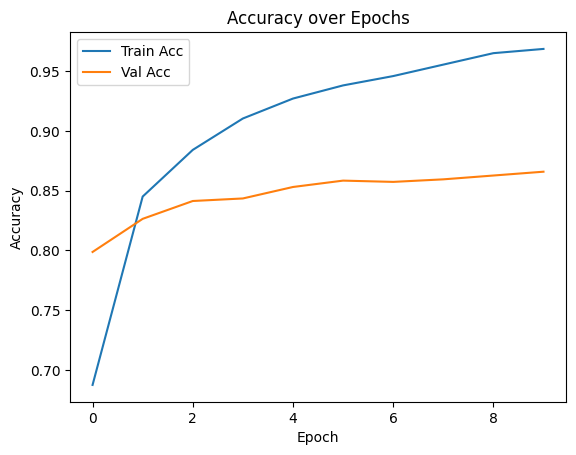

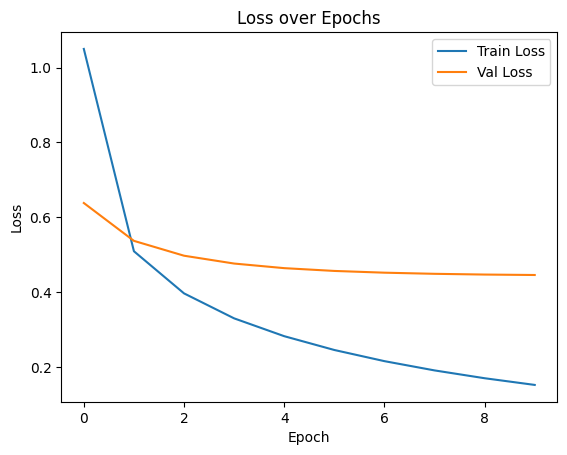

In [24]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [25]:

val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation accuracy: {val_accuracy:.4f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 284ms/step - accuracy: 0.8601 - loss: 0.4509
Validation accuracy: 0.8658
